In [1]:
import ax as ax

import tensorflow as tf
import numpy as np
import pickle as pkl
from tensorflow.keras.applications.xception import preprocess_input
from skimage.io import imread
from tensorflow import keras
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.keras.callbacks import TensorBoard
from time import time





In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices(device_type='GPU')

x_train_filenames = []
y_train_labels = []
x_test_filenames = []
y_test_labels = []
training_file_names = np.load('Training_file_names.npy', allow_pickle=True)
test_file_names = np.load('Test_file_names.npy', allow_pickle=True)
for name, label in training_file_names:
    x_train_filenames.append(name)
    y_train_labels.append(label)
i = 0
for xname, xlabel in test_file_names:
    i += 1
    if i == 20:
        break
    x_test_filenames.append(xname)
    y_test_labels.append(xlabel)

x_train_filenames = np.array(x_train_filenames)
x_test_filenames = np.array(x_test_filenames)
print(x_train_filenames.shape, x_test_filenames.shape)


batch_size = 20
img_height = 200
img_width = 200

Num GPUs Available:  1
(66967,) (19,)


In [3]:
#this generator class breaks up training data into batches so the model doesn't run out of VRAM while training
# class My_Custom_Generator(keras.utils.Sequence):
#     def __init__(self, image_filenames, labels, batch_size) :
#         self.image_filenames = image_filenames
#         self.labels = labels
#         self.batch_size = batch_size
#
#
#     def __len__(self) :
#         return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)
#
#
#     def __getitem__(self, idx) :
#         batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
#         batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
#         x = preprocess_input(np.array([
#             imread(str(file_name))
#             for file_name in batch_x]))
#
#         #one hot encoding
#         y = np.array(batch_y)
#         y = tf.keras.utils.to_categorical(y)
#         #flatten and normalize
#         return x, y

In [4]:
# my_training_batch_generator = My_Custom_Generator(x_train_filenames, y_train_labels, batch_size)
# my_validation_batch_generator = My_Custom_Generator(x_test_filenames, y_test_labels, 128)

label: 37


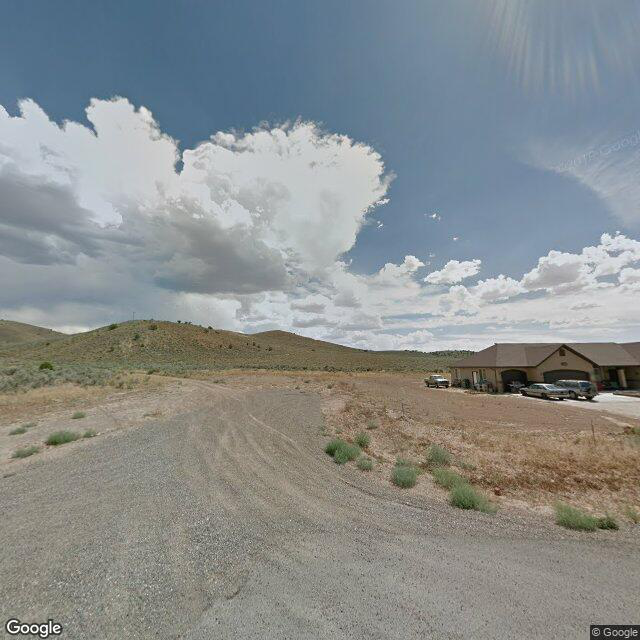

In [5]:
print(f'label: {y_train_labels[0]}')
sample_image = imread(f'{x_train_filenames[0]}')
Image.fromarray(sample_image)

In [6]:


from tensorflow.keras import datasets, layers, models
cnn = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(640, 640, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(243, activation='softmax')
])







In [7]:
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir='logs_model_1.2/{}'.format(time()))

In [ ]:
class My_Custom_Generator(keras.utils.Sequence):
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size


    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)


    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = [eval(i) for i in batch_y]
        batch_y = np.array(batch_y)
        x = preprocess_input(np.array([
            imread(str(file_name))
            for file_name in batch_x]))

        # x = x.reshape(8,640,640,1)
        # plt.imshow(x[0])
        # plt.show()
        #one hot encoding
        # y = np.array(batch_y)
        # y = tf.keras.utils.to_categorical(y)

        # batch_y = tf.keras.utils.to_categorical(batch_y)



        return x, batch_y
my_training_batch_generator = My_Custom_Generator(x_train_filenames, y_train_labels, batch_size)
my_validation_batch_generator = My_Custom_Generator(x_test_filenames, y_test_labels, 128)
accHistory = []

for i in range(100):
        h = cnn.fit(x = my_training_batch_generator, epochs = 1, callbacks=[tensorboard])
        accHistory.append(h.history['accuracy'])
        cnn.save(f'Backups_1.2/Backup_{i+1}')

cnn.save('cnnmodel_1.2.model')

3349/3349 [==============================] - 717s 214ms/step - loss: 5.1035 - accuracy: 0.0160
INFO:tensorflow:Assets written to: Backups_1.2/Backup_1/assets
3349/3349 [==============================] - 704s 210ms/step - loss: 4.5611 - accuracy: 0.0518
INFO:tensorflow:Assets written to: Backups_1.2/Backup_2/assets
 735/3349 [=====>........................] - ETA: 9:20 - loss: 3.7766 - accuracy: 0.1454

In [ ]:
model =  tf.keras.models.load_model('cnnmodel_1.2.model')

In [ ]:
from numpy import asarray

test_data = []
for file in x_test_filenames:
    img = Image.open(file)
    np_image = asarray(img)
    test_data.append(np_image)
test_data = np.array(test_data)
y_test_labels = [eval(i) for i in y_test_labels]
test_labels = np.array(y_test_labels)

test_loss, test_accuracy = model.evaluate(test_data, test_labels)

In [ ]:
predictions = model.predict([test_data])

In [ ]:
print(predictions)

In [ ]:
from matplotlib.figure import Figure as fig

print(np.argmax(predictions[15]))
print(x_test_filenames[15])
plt.imshow(test_data[15])

In [ ]:
from shapely.geometry import Polygon, Point

#### importing plot of usa that is made up of hundreds of grids defined as points
usaPolyGrid = pkl.load(open("util/usaPolyGrid.pkl", 'rb'))
for i in usaPolyGrid.values():
    plt.plot(i[:, 1], i[:, 0])
print(len(usaPolyGrid))

count = 0
for i in usaPolyGrid.values():
    if count != 105:
        plt.plot(i[:,1],i[:,0], c='blue')
    count += 1
print(len(usaPolyGrid))

poly = Polygon(np.flip(usaPolyGrid[105]))
x,y = poly.exterior.xy
plt.plot(x,y, c='red')
plt.show()